1. Data Preparation:
Load and clean the dataset (events.csv).
Parse event_time to datetime format and ensure other columns have appropriate data types.
Handle missing, duplicate, or inconsistent data.

2. Exploratory Data Analysis (EDA):
Analyze event distributions (view, cart, purchase) over time.
Identify patterns in user behavior and product preferences.
Investigate anomalies in the data.

3. Churn Definition:
In the context of this e-commerce platform, churn can be defined as follows:
A user is considered to have churned if they have not made any purchases or site visits (e.g., "view", "cart", or "purchase" events) within the last 30 days.

4. Feature Engineering:
User-level features:
RFM metrics (Recency, Frequency, Monetary).
Session-based metrics (session count, average session duration).
Behavioral patterns (view-to-cart and cart-to-purchase ratios).
Product/brand preferences (most viewed/purchased brands and categories).

5. Predictive Modeling:
Use models like logistic regression, decision trees, or gradient boosting.
Validate with metrics such as Precision, Recall, AUC, F1-score, and others.
Interpretation & Insights

Use tools like SHAP values to determine feature importance.
Analyze which user behaviors and product features are most influential for churn.

In [1]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


Data Overview:
                  event_time event_type  product_id          category_id  \
0 2020-09-24 11:57:06+00:00       view     1996170  2144415922528452715   
1 2020-09-24 11:57:26+00:00       view      139905  2144415926932472027   
2 2020-09-24 11:57:27+00:00       view      215454  2144415927158964449   
3 2020-09-24 11:57:33+00:00       view      635807  2144415923107266682   
4 2020-09-24 11:57:36+00:00       view     3658723  2144415921169498184   

                   category_code        brand   price    user_id user_session  
0          electronics.telephone      unknown   31.90 -796125589   LJuJVLEjPT  
1    computers.components.cooler       zalman   17.16 -796133445   tdicluNnRY  
2                        unknown      unknown    9.81 -802275341   4TMArHtXQy  
3  computers.peripherals.printer       pantum  113.81 -796499500   aGFYrNgC08  
4                        unknown  cameronsino   15.87 -804770512   aa4mmk0kwQ  

Data Info:
<class 'pandas.core.frame.DataFrame'>
Ran

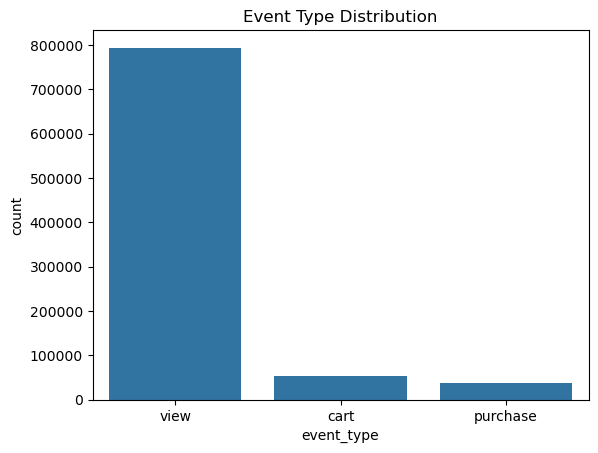

<Figure size 1200x600 with 0 Axes>

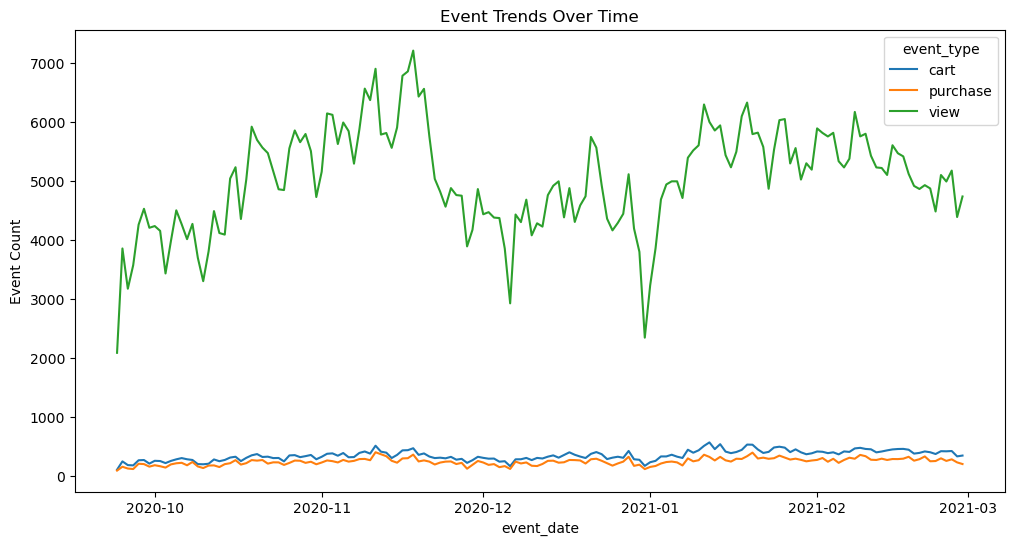

Average Price Per Category:
 category_code
electronics.video.projector            746.783598
appliances.kitchen.washer              666.670000
electronics.audio.music_tools.piano    436.800265
country_yard.cultivator                429.077704
computers.components.videocards        385.903288
Name: price, dtype: float64


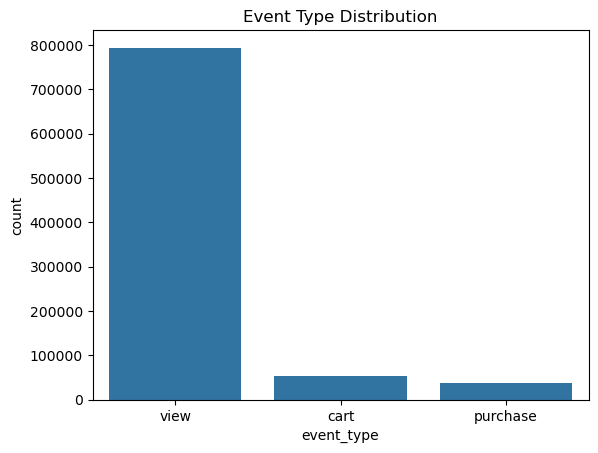

KeyboardInterrupt: 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, f1_score
import shap

# Load the dataset
data = pd.read_csv("events.csv")

# Data Preprocessing
# Convert event_time to datetime format
data['event_time'] = pd.to_datetime(data['event_time'])

# Handle missing values
data.fillna({
    'category_code': 'unknown',
    'brand': 'unknown'
}, inplace=True)

# Parse dates and ensure data types are correct
data = data.astype({
    'price': 'float',
    'user_id': 'int',
    'product_id': 'int'
})

# Exploratory Data Analysis (EDA)
print("Data Overview:\n", data.head())
print("\nData Info:")
data.info()

# Distribution of event types
sns.countplot(x='event_type', data=data)
plt.title('Event Type Distribution')
plt.show()

# Analyze trends over time
data['event_date'] = data['event_time'].dt.date
plt.figure(figsize=(12, 6))
data.groupby('event_date')['event_type'].value_counts().unstack().plot(kind='line', figsize=(12, 6))
plt.title('Event Trends Over Time')
plt.ylabel('Event Count')
plt.show()

# Analyzing average price per category
avg_price_per_category = data.groupby('category_code')['price'].mean().sort_values(ascending=False)
print("Average Price Per Category:\n", avg_price_per_category.head())
# Distribution of event types
sns.countplot(x='event_type', data=data)
plt.title('Event Type Distribution')
plt.show()

# User-level aggregation for feature engineering
user_data = data.groupby('user_id').agg(
    recency=('event_time', lambda x: (data['event_time'].max() - x.max()).days),
    frequency=('event_type', 'count'),
    monetary=('price', 'sum'),
    view_count=('event_type', lambda x: (x == 'view').sum()),
    cart_count=('event_type', lambda x: (x == 'cart').sum()),
    purchase_count=('event_type', lambda x: (x == 'purchase').sum()),
    avg_price=('price', 'mean'),
    unique_brands=('brand', 'nunique'),
    unique_categories=('category_code', 'nunique')
).reset_index()

# Feature engineering: Calculate ratios
user_data['view_to_cart_ratio'] = user_data['cart_count'] / (user_data['view_count'] + 1e-5)
user_data['cart_to_purchase_ratio'] = user_data['purchase_count'] / (user_data['cart_count'] + 1e-5)

# Define churn: Users who haven't purchased in the last 30 days
user_data['churn'] = (user_data['recency'] > 30).astype(int)

In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score

# Assuming user_data is a Pandas DataFrame
# Prepare data for modeling
X = user_data.drop(columns=['user_id', 'churn'])
y = user_data['churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Customize hyperparameters and perform cross-validation
model = GradientBoostingClassifier(
    learning_rate=0.05,  # Shrinks the contribution of each tree
    n_estimators=50,    # Number of boosting stages
    max_depth=4,         # Maximum depth of each tree
    random_state=42      # Ensure reproducibility
)

# Perform cross-validation on the entire dataset
scores = cross_val_score(model, X, y, cv=3, scoring='roc_auc', n_jobs=-1)
print(f"Average ROC-AUC Score (Default Model): {scores.mean():.4f}")

print(f"Average ROC-AUC Score (Cross-Validation): {scores.mean():.4f}")

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Predicted probabilities for the positive class

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score (Test Set):", roc_auc_score(y_test, y_pred_prob))

In [ ]:
# Feature importance and SHAP analysis
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Recommendations based on findings
print("\nBusiness Recommendations:")
print("1. Target high-recency users with personalized campaigns.")
print("2. Offer discounts or incentives to users with high view-to-cart ratios.")
print("3. Improve onboarding for first-time buyers.")

# Save processed data and model for reproducibility
user_data.to_csv('processed_user_data.csv', index=False)
import joblib
joblib.dump(model, 'churn_model.pkl')